# Evaluations For Binary Classification Models

link to series
list of workflows in series

motivation
descriptions
workflow overview

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('bigframes', 'bigframes'),
    ('sklearn', 'scikit-learn'),
    ('numpy', 'numpy'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'), 
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('matplotlib', 'matplotlib')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
SERIES = 'mlops'
EXPERIMENT = 'evaluation-classification-binary'

# Set the name of GCS Bucket to read/write to
GCS_BUCKET = PROJECT_ID

# Data source for this workflow
BQ_SOURCE = 'bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

packages:

In [40]:
import os
import sklearn.metrics
import sklearn.ensemble
import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt

import bigframes.pandas as bpd
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

clients:

In [9]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION, experiment = SERIES+'-'+EXPERIMENT)

# gcs storage client
gcs = storage.Client(project = GCS_BUCKET)
bucket = gcs.bucket(GCS_BUCKET)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# bigframes setup
bpd.options.bigquery.project = PROJECT_ID

Parameters:

In [10]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [11]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Review Source Data: New York City Yellow Cab Trips (2017)

This is a BigQuery public table containing 113,500,316 individual yellow cab trip records for the year 2017, provided by the New York City Taxi and Limousine Commission (TLC). For our **binary classification** task, we will derive a target variable indicating whether a tip was left or not.

The table includes a rich set of descriptive features, including:

* **`vendor_id`** (string): A code indicating the TPEP provider that provided the record.
* **`pickup_datetime`** (timestamp): The date and time when the meter was engaged.
* **`dropoff_datetime`** (timestamp): The date and time when the meter was disengaged.
* **`passenger_count`** (integer): The number of passengers in the vehicle (driver excluded).
* **`trip_distance`** (float): The elapsed trip distance in miles reported by the taximeter.
* **`fare_amount`** (float): The time-and-distance fare calculated by the meter.
* **`tip_amount`** (float): The amount of tip. This is the basis for our binary target variable.
* **`total_amount`** (float): The total amount charged to the passenger.
* And other columns related to payment type, tolls, etc.

From the **`tip_amount`** column, we will derive our binary target: `has_tip` (1 if `tip_amount > 0`, 0 otherwise).

You can research more about this dataset, including its comprehensive schema and history, at the [NYC Taxi & Limousine Commission website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) or within the BigQuery public dataset documentation.

Read more about BigQuery public datasets [here](https://cloud.google.com/bigquery/public-data).
 

### Review BigQuery table:

In [12]:
source_data = bpd.read_gbq(BQ_SOURCE)
source_data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
0,1,2017-02-16 19:32:28+00:00,2017-02-16 20:04:21+00:00,1,10.100000000,1,N,1,33.000000000,1.000000000,0.500000000,6.950000000,0E-9,0.300000000,<NA>,41.750000000,138,79,2017,2
1,2,2017-11-09 15:30:47+00:00,2017-11-09 15:41:07+00:00,1,1.170000000,1,N,1,8.000000000,0E-9,0.500000000,1.000000000,0E-9,0.300000000,<NA>,9.800000000,141,162,2017,11
2,1,2017-11-02 08:42:13+00:00,2017-11-02 08:44:18+00:00,1,0.400000000,1,N,1,3.500000000,0E-9,0.500000000,1.050000000,0E-9,0.300000000,<NA>,5.350000000,141,237,2017,11
3,1,2017-09-26 18:49:21+00:00,2017-09-26 19:11:20+00:00,1,3.300000000,1,N,2,16.000000000,1.000000000,0.500000000,0E-9,0E-9,0.300000000,<NA>,17.800000000,48,114,2017,9
4,1,2017-10-08 03:20:00+00:00,2017-10-08 03:21:22+00:00,1,0.300000000,1,N,2,3.000000000,0.500000000,0.500000000,0E-9,0E-9,0.300000000,<NA>,4.300000000,48,48,2017,10


In [13]:
source_data.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 113500316 entries, 0 to 113500315
Data columns (total 20 columns):
  #  Column               Dtype
---  -------------------  ------------------------------
  0  vendor_id            string
  1  pickup_datetime      timestamp[us, tz=UTC][pyarrow]
  2  dropoff_datetime     timestamp[us, tz=UTC][pyarrow]
  3  passenger_count      Int64
  4  trip_distance        decimal128(38, 9)[pyarrow]
  5  rate_code            string
  6  store_and_fwd_flag   string
  7  payment_type         string
  8  fare_amount          decimal128(38, 9)[pyarrow]
  9  extra                decimal128(38, 9)[pyarrow]
 10  mta_tax              decimal128(38, 9)[pyarrow]
 11  tip_amount           decimal128(38, 9)[pyarrow]
 12  tolls_amount         decimal128(38, 9)[pyarrow]
 13  imp_surcharge        decimal128(38, 9)[pyarrow]
 14  airport_fee          decimal128(38, 9)[pyarrow]
 15  total_amount         decimal128(38, 9)[pyarrow]
 16  pickup_location_id   string
 17  drop

---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with 10% for training (`TRAIN`), 1% for validation (`VALIDATE`) and 1% for testing (`TEST`) - 82% is left as null for this stage of training.  Additionally, a unique identifier was added to each transaction, `trip_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [14]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding columns:
- `transaction_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [15]:
job = bq.query(f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    base_data AS (
        SELECT
            -- Categorical features (ensure string casting if not already)
            vendor_id, -- Already string
            rate_code, -- Already string
            payment_type, -- Already string
            store_and_fwd_flag, -- Already string
            pickup_location_id, -- Already string
            dropoff_location_id, -- Already string
            CASE WHEN airport_fee > 0 THEN 1 ELSE 0 END AS has_airport_fee, -- create categorical variable for airport_fee
            
            -- Numerical features
            passenger_count,
            trip_distance,
            fare_amount,
            extra,
            mta_tax,
            tip_amount, -- Used for target, but also useful as a feature for other tasks
            tolls_amount,
            imp_surcharge,
            total_amount,

            -- Derived features
            TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) AS trip_duration_seconds,
            
            -- Raw timestamps for potential future BigFrames datetime operations or direct use
            pickup_datetime,
            dropoff_datetime,

            -- Create the binary target: has_tip
            CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END AS has_tip,
            -- Add an ID and row number for stratified splitting
            GENERATE_UUID() AS trip_id,
            ROW_NUMBER() OVER (PARTITION BY (CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END) ORDER BY RAND()) as rn
        FROM `{BQ_SOURCE}`
        WHERE
            -- Basic filtering for valid trips: positive duration, passengers, and non-zero fare/tip amounts
            TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) > 0 AND
            passenger_count > 0 AND
            fare_amount > 0 AND
            tip_amount IS NOT NULL -- Exclude trips where tip_amount is unknown
            AND pickup_datetime BETWEEN '2017-01-01 00:00:00' AND '2017-12-31 23:59:59' -- Filter for 2017 data only
            -- You might add more filtering for outliers like extremely long distances, or invalid coordinates if available

    )
SELECT
    * EXCEPT(rn),
    CASE -- 10% for train, 1% for validation, 1% for test
        WHEN rn <= 0.01 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'TRAIN'
        WHEN rn <= 0.0125 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'VALIDATE'
        WHEN rn <= 0.015 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'TEST'
        ELSE Null -- records not samples for using in training here
    END AS splits
FROM
    base_data
""")
job.result()
(job.ended-job.started).total_seconds()

31.942

In [16]:
source_data_prepared = bpd.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}", use_cache = False)
source_data_prepared.head()

,vendor_id,rate_code,payment_type,store_and_fwd_flag,pickup_location_id,dropoff_location_id,has_airport_fee,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,imp_surcharge,total_amount,trip_duration_seconds,pickup_datetime,dropoff_datetime,has_tip,trip_id,splits
0,2,1,1,N,125,211,0,2,0.300000000,4.000000000,...,0.960000000,0E-9,0.300000000,5.760000000,218,2017-05-03 12:15:02+00:00,2017-05-03 12:18:40+00:00,1,b37614b9-8b60-4e19-b105-4675270e8e4d,<NA>
1,2,1,1,N,246,186,0,2,0.900000000,17.500000000,...,3.660000000,0E-9,0.300000000,21.960000000,1752,2017-12-13 13:26:18+00:00,2017-12-13 13:55:30+00:00,1,96b49529-c424-49f9-bdfc-f69f13312d7d,<NA>
2,1,1,2,N,234,43,0,1,5.100000000,20.500000000,...,0E-9,0E-9,0.300000000,21.300000000,1406,2017-01-08 14:00:10+00:00,2017-01-08 14:23:36+00:00,0,488adff2-4286-42c1-8925-0501256f67ed,<NA>
3,2,1,1,N,41,238,0,6,1.600000000,8.500000000,...,1.000000000,0E-9,0.300000000,10.800000000,518,2017-11-12 21:28:04+00:00,2017-11-12 21:36:42+00:00,1,a090892f-85c2-40b5-8e8c-075fac26880c,<NA>
4,2,1,1,N,161,54,0,1,7.860000000,27.000000000,...,0E-9,0E-9,0.300000000,28.300000000,1907,2017-12-13 21:38:06+00:00,2017-12-13 22:09:53+00:00,0,2c6f8b34-2122-4831-8038-60e225b2cde9,<NA>


### Review the number of records for each level of `Class` for each of the data splits:

In [17]:
bq.query(f"""
SELECT splits, has_tip,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY has_tip), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, has_tip
ORDER BY has_tip, splits
""").to_dataframe()

,splits,has_tip,count,percentage
0,None,0,39648293,98.50
1,TEST,0,100631,0.25
2,TRAIN,0,402520,1.00
3,VALIDATE,0,100630,0.25
4,None,1,71798886,98.50
5,TEST,1,182231,0.25
6,TRAIN,1,728922,1.00
7,VALIDATE,1,182231,0.25


### Further Data Preparation



#### Rows Assigned To A Split (TRAIN, TEST, VALIDATE)

Avoid the unsampled rows where `splits = Null`:

In [18]:
# only use rows assigned to a split:
source_data_prepared_filtered = source_data_prepared[source_data_prepared['splits'].notna()]

#### Group Columns By Type

In [19]:
# Numerical columns
numerical_cols = [
    'trip_duration_seconds',
    'passenger_count',
    'trip_distance',
    'fare_amount',
    'extra',
    'mta_tax',
    'tolls_amount',
    'imp_surcharge',
    'total_amount'
]

# Categorical columns
categorical_cols = [
    'vendor_id',
    'rate_code',
    'payment_type',
    'store_and_fwd_flag',
    'pickup_location_id',
    'dropoff_location_id',
    'has_airport_fee'
]

target_col = 'has_tip'
split_col = 'splits'
id_col = 'trip_id' # Keep id for later lookup if needed, but not as a feature
datetime_cols = ['pickup_datetime', 'dropoff_datetime'] # Keep these if you want to derive more features in BigFrames


#### Check For Columns With NaNs

In [20]:
source_data_prepared_filtered[numerical_cols + categorical_cols + [target_col]].isna().sum()

trip_duration_seconds    0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tolls_amount             0
imp_surcharge            0
total_amount             0
vendor_id                0
rate_code                0
payment_type             0
store_and_fwd_flag       0
pickup_location_id       0
dropoff_location_id      0
has_airport_fee          0
has_tip                  0
dtype: Int64

#### Setup Pointers For Training

In [21]:
X_frame = source_data_prepared_filtered[numerical_cols + categorical_cols]
y_frame = source_data_prepared_filtered[target_col]
splits_frame = source_data_prepared_filtered[split_col]

print(f"There are {X_frame.shape[0]} training rows for {X_frame.shape[1]} raw features.")
print(f"Confirming the rows for splits and the label are {splits_frame.shape[0]} and {y_frame.shape[0]} respectively.")

There are 1697165 training rows for 16 raw features.
Confirming the rows for splits and the label are 1697165 and 1697165 respectively.


---
## Train With Scikit-Learn

### Local Dataframes

Convert the Bigframes pointers to Pandas dataframes for the training objects:

In [22]:
X_train = X_frame[splits_frame == 'TRAIN'].to_pandas()
X_val = X_frame[splits_frame == 'VALIDATE'].to_pandas()
X_test = X_frame[splits_frame == 'TEST'].to_pandas()

y_train = y_frame[splits_frame == 'TRAIN'].to_pandas()
y_val = y_frame[splits_frame == 'VALIDATE'].to_pandas()
y_test = y_frame[splits_frame == 'TEST'].to_pandas()

In [23]:
X_train.shape, y_train.shape

((1131442, 16), (1131442,))

### Define A Preprocessor

Create a Scikit-Learn preprocessor that standardizes numeric variables and one-hot encodes categorical variables:

In [24]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        # Apply StandardScaler to numerical columns
        ('num', sklearn.preprocessing.StandardScaler(), numerical_cols),
        # Apply OneHotEncoder to categorical columns
        ('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), categorical_cols)
    ],
    remainder = 'passthrough' # Keep any other columns not explicitly listed (if any) as they are
)

### Define A Model Pipeline: Proprocessor + Model

Combine the preprocessor with the model type in a pipeline:

In [25]:
model_pipeline = sklearn.pipeline.Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', sklearn.ensemble.RandomForestClassifier(random_state=42, n_jobs=-1))
    ]
)

### Train/Fit The Model

Use the training data to train the model using the pipeline:

In [26]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['trip_duration_seconds',
                                                   'passenger_count',
                                                   'trip_distance',
                                                   'fare_amount', 'extra',
                                                   'mta_tax', 'tolls_amount',
                                                   'imp_surcharge',
                                                   'total_amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vendor_id', 'rate_code',
                                                   'payment_type',
                                                   'store_and_fwd_flag',
                                                   'pickup_location_id',
                                                   'dropoff_location_id',
                                                   'has_airport_fee'])])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

---
## Evaluate The Model

Use the [Scikit-Learn metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html) module to get evaluation metrics for the model on data splits.

In [32]:
y_pred_class_test = model_pipeline.predict(X_test)
y_pred_proba_test = model_pipeline.predict_proba(X_test)[:, 1]

In [33]:
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_class_test)
test_roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
test_log_loss = sklearn.metrics.log_loss(y_test, y_pred_proba_test)

print(f"Accuracy (TEST): {test_accuracy:.4f}")
print(f"ROC AUC (TEST): {test_roc_auc:.4f}")
print(f"Log Loss (TEST): {test_log_loss:.4f}")

Accuracy (TEST): 0.9842
ROC AUC (TEST): 0.9995
Log Loss (TEST): 0.0417


In [ ]:
print("\nClassification Report (TEST Split):")
print(sklearn.metrics.classification_report(y_test, y_pred_class_test))


Classification Report (TEST Split):
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    100631
         1.0       0.98      1.00      0.99    182231

    accuracy                           0.98    282862
   macro avg       0.99      0.98      0.98    282862
weighted avg       0.98      0.98      0.98    282862



In [36]:
print("\nConfusion Matrix (TEST Split):")
print(sklearn.metrics.confusion_matrix(y_test, y_pred_class_test))


Confusion Matrix (TEST Split):
[[ 96241   4390]
 [    78 182153]]


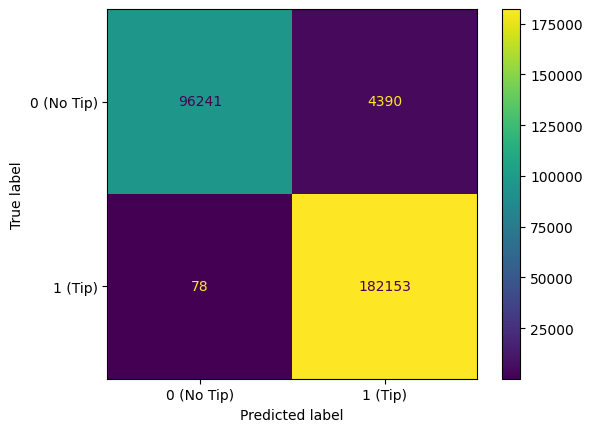

In [38]:
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_class_test),
    display_labels=['0 (No Tip)', '1 (Tip)']
)
disp.plot()

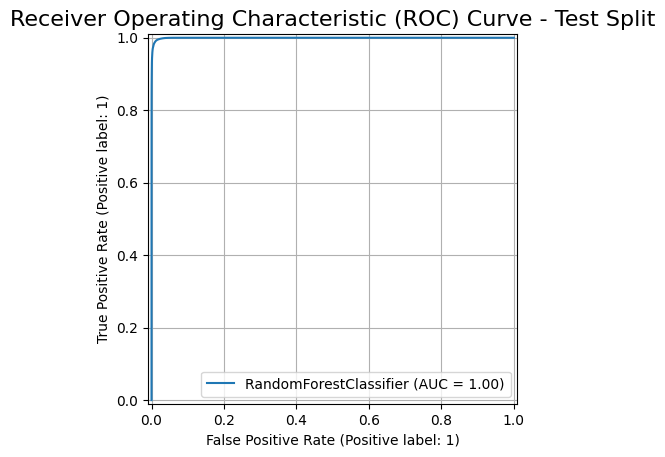

In [45]:
roc_display = sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_proba_test,
    name = 'RandomForestClassifier'
)
#roc_display.plot()
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Split', fontsize=16)
plt.grid(True) # Add a grid for better readability
plt.show() # Display the plot

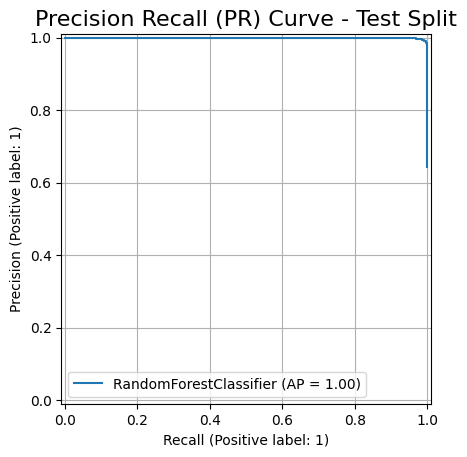

In [46]:
pr_display = sklearn.metrics.PrecisionRecallDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_proba_test,
    name = 'RandomForestClassifier'
)
#pr_display.plot()
plt.title('Precision Recall (PR) Curve - Test Split', fontsize=16)
plt.grid(True) # Add a grid for better readability
plt.show() # Display the plot

---
## Register The Model In Vertex AI Model Registry

### Save The Model

### Move The Model To GCS

### Register The Model

Pick a prebuilt serving container

---
## Load Model Evaluations To The Vertex Ai Model Registry

The versioned models in Vertex AI Model Registry can include evaluations.  Here the evaluations for each split of the data are loaded to the registry for the model version uploaded above.

### Structured Evaluation

The provided ...

In [28]:
evaluations = {}

data_splits = {
    'TRAIN': (X_train, y_train),
    'VALIDATE': (X_val, y_val),
    'TEST': (X_test, y_test)
}

In [30]:
for split_name, (X_split, y_split) in data_splits.items():
    # predictions
    y_pred_proba = model_pipeline.predict_proba(X_split)[:, 1]
    y_pred_class_default_threshold = (y_pred_proba >= 0.5).astype(int)
    # overall metrics
    au_prc_val = sklearn.metrics.average_precision_score(y_split, y_pred_proba)
    au_roc_val = sklearn.metrics.roc_auc_score(y_split, y_pred_proba)
    log_loss_val = sklearn.metrics.log_loss(y_split, y_pred_proba)
    overall_conf_matrix = sklearn.metrics.confusion_matrix(y_split, y_pred_class_default_threshold, labels=[0, 1])
    # confidence metrics for splits
    confidence_thresholds = (
        list(np.arange(0.0, 1.0, 0.05)) + # 0.00, 0.05, ..., 0.95
        list(np.arange(0.95, 1.0, 0.01))  # 0.95, 0.96, ..., 0.99
    )
    confidence_thresholds = sorted(list(set([round(t, 2) for t in confidence_thresholds])))
    confidence_metrics_list = []
    for threshold in confidence_thresholds:
        y_pred_at_threshold = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1]).ravel()
        recall_val = sklearn.metrics.recall_score(y_split, y_pred_at_threshold, zero_division=0)
        precision_val = sklearn.metrics.precision_score(y_split, y_pred_at_threshold, zero_division=0)
        false_positive_rate_val = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        f1_score_val = sklearn.metrics.f1_score(y_split, y_pred_at_threshold, zero_division=0)
        confidence_metrics_entry = {
            'confidenceThreshold': threshold,
            'maxPredictions': 2147483647, # As per schema
            'recall': recall_val,
            'precision': precision_val,
            'falsePositiveRate': false_positive_rate_val,
            'f1Score': f1_score_val,
            # f1ScoreMicro and f1ScoreMacro are typically for multi-class/multi-label, omitted for binary simplicity
            # recallAt1, precisionAt1, etc. are for top-k predictions, typically not applicable for standard binary thresholding
            'truePositiveCount': int(tp),
            'falsePositiveCount': int(fp),
            'falseNegativeCount': int(fn),
            'trueNegativeCount': int(tn),
            'confusionMatrix': { # Optional confusion matrix for each threshold
                'annotationSpecs': [{'displayName': '0'}, {'displayName': '1'}], # Assuming class labels are 0 and 1
                'rows': [{'row': sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1])[0].tolist()},
                         {'row': sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1])[1].tolist()}]
            }
        }
        confidence_metrics_list.append(confidence_metrics_entry)
    evaluations[split_name] = {
        'auPrc': au_prc_val,
        'auRoc': au_roc_val,
        'logLoss': log_loss_val,
        'confidenceMetrics': confidence_metrics_list,
        'confusionMatrix': { # Overall confusion matrix at default 0.5 threshold
            'annotationSpecs': [{'displayName': '0'}, {'displayName': '1'}],
            'rows': [{'row': overall_conf_matrix[0].tolist()},
                     {'row': overall_conf_matrix[1].tolist()}]
        }
    }

In [31]:
evaluations['TEST']

{'auPrc': np.float64(0.9996381749437449),
 'auRoc': np.float64(0.999471461685301),
 'logLoss': 0.04165879071493631,
 'confidenceMetrics': [{'confidenceThreshold': np.float64(0.0),
   'maxPredictions': 2147483647,
   'recall': 1.0,
   'precision': 0.6442399473948427,
   'falsePositiveRate': np.float64(1.0),
   'f1Score': 0.7836325208076664,
   'truePositiveCount': 182231,
   'falsePositiveCount': 100631,
   'falseNegativeCount': 0,
   'trueNegativeCount': 0,
   'confusionMatrix': {'annotationSpecs': [{'displayName': '0'},
     {'displayName': '1'}],
    'rows': [{'row': [0, 100631]}, {'row': [0, 182231]}]}},
  {'confidenceThreshold': np.float64(0.05),
   'maxPredictions': 2147483647,
   'recall': 1.0,
   'precision': 0.9564776956063048,
   'falsePositiveRate': np.float64(0.08240005564885572),
   'f1Score': 0.9777547658777639,
   'truePositiveCount': 182231,
   'falsePositiveCount': 8292,
   'falseNegativeCount': 0,
   'trueNegativeCount': 92339,
   'confusionMatrix': {'annotationSpecs':

- Register Model To Vertex Model Registry: joblib to loca, move to gcs, load with prebuilt
- Add Evaluations to Registry: Test and Train and even validate
- Add customized evalaution, review the yaml and edit it
